# Noise Reduction with Spectral Subtraction

## Table of Contents

1. [Introduction](#intro)  
2. [Setup & Dependencies](#libraries)  
3. [Configuration](#configuration)  
4. [Helper Functions](#helpfn)  
5. [Load & Denoise](#load)  
6. [Insert Dummy Data](#dummy)  
7. [Visualization](#visualise)  
8. [External Test Case](#external)  
9. [Save Output](#save)  
10. [Conclusion](#conclusion)

<a id="intro"></a>
## 1. Introduction

In this project we demonstrate **spectral subtraction**, a classical audio denoising method. 

- **Idea**: Estimate the noise spectrum from a short “noisy‐only” segment, subtract it from every frame of your recording in the frequency domain, then reconstruct via inverse STFT.
- **Applications**: Speech enhancement, audio restoration, preprocessing for ASR.

<a id="libraries"></a>
## Setup and Dependencies 

Make sure you have the following Python packages installed:

```bash
pip install numpy librosa soundfile matplotlib scipy
```

In [ ]:
# Import required libraries
import os
import numpy as np  # numerical operations
# Fix compatibility for librosa on numpy >=1.24
np.complex = complex
# np.complex is a function, and complex is a class used by librosa to do the same thing, i.e, create complex numbers.

import librosa        # audio I/O & processing
import librosa.display
import soundfile as sf  # reading/writing WAV files
import matplotlib.pyplot as plt
from scipy.signal import stft, istft  # STFT operations

print('Libraries imported successfully!')

Libraries imported successfully!


<a id="configuration"></a>
## Configuration

Set up file paths and processing parameters:

In [ ]:
# File paths
noisy_file = './noisy_sample.wav'                   # Input file
out_file   = './Demo/noisy_sample_denoised.wav'     # Output file

# STFT parameters
frame_len = 2048
hop_len = 512

# sampling rate (in Hz)
sr = 44100

Dummy samples at start: 441


<a id="helpfn"></a>
## Helper Functions

In [4]:
def extract_noise_profile(y, sr, duration=0.5):
    """
    Estimate an average magnitude spectrum from the first duration seconds of y.
    """
    n = int(sr * duration)
    noise = y[:n]
    _, _, Zxx = stft(noise, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    return np.mean(np.abs(Zxx), axis=1)


def spectral_subtract(y, sr, noise_spec):
    """
    Subtract noise_spec from the full signal in magnitude domain, then invert.
    """
    _, _, Zxx = stft(y, fs=sr, nperseg=frame_len,
                     noverlap=frame_len-hop_len, boundary=None)
    mag, phase = np.abs(Zxx), np.angle(Zxx)
    sub_mag = np.maximum(mag - noise_spec[:, None], 0.0)
    _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,
                     nperseg=frame_len, noverlap=frame_len-hop_len,
                     boundary=None)
    # Ensure same length
    y_rec = librosa.util.fix_length(y_rec, size=len(y))
    return y_rec

<a id="load"></a>
## Load the file & Denoise

In [5]:
# Load noisy audio
y_noisy, sr = librosa.load(noisy_file, sr=None)
print(f"Loaded noisy audio: {noisy_file}, sr={sr}, duration={len(y_noisy)/sr:.2f}s")

# Estimate noise profile
noise_spec = extract_noise_profile(y_noisy, sr, duration=0.5)

# Apply spectral subtraction
y_denoised = spectral_subtract(y_noisy, sr, noise_spec)
print('Denoising complete!')

Loaded noisy audio: ./noisy_sample.wav, sr=48000, duration=9.30s
Denoising complete!


C:\Users\Aryan Gupta\AppData\Local\Temp\ipykernel_11148\4250752076.py:20: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, y_rec = istft(sub_mag * np.exp(1j * phase), fs=sr,


<a id="visualise"></a>
## Visualization

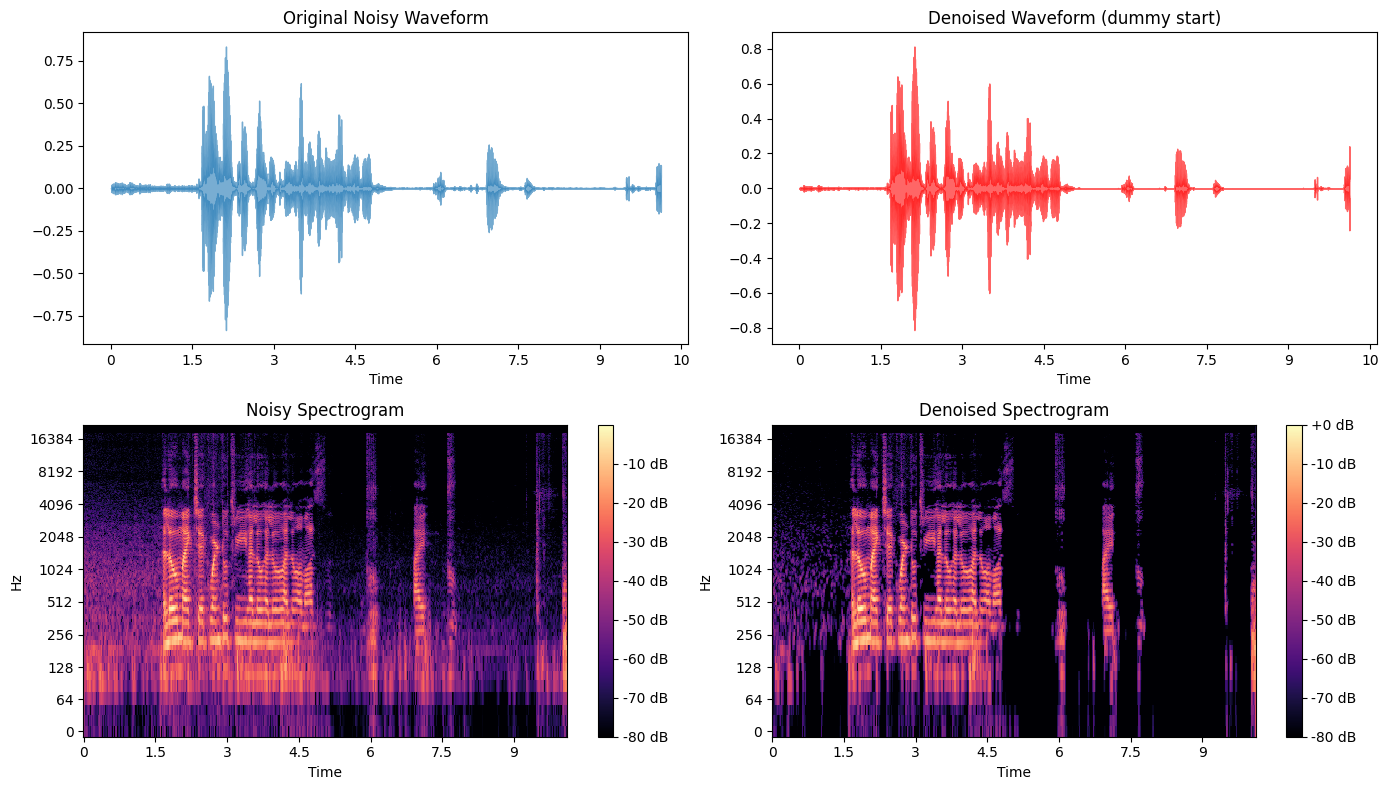

In [11]:
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Original Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform (dummy start)')

# Spectrograms
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=frame_len, hop_length=hop_len)), ref=np.max)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)), ref=np.max)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()

As we can see, there is a noticeable dip at the start of the file. This occurs due to the application of the STFT — since we do not have any data at *t = 0*, the signal is still undergoing spectral subtraction, resulting in the observed dip.  
*Note: There is no actual error in the audio output at this point.*

---

To address this, we will add a small amount of dummy data at the beginning to counter the issue and produce a smoother plot.

<a id="dummy"></a>
## Insert Dummy Data

In [ ]:
# Dummy data insertion
margin_ms = 5  # milliseconds to replace at start
n_dummy = int(margin_ms * 1e-3 * sr)

print(f'Dummy samples at start: {n_dummy}')

# Overwrite first n_dummy samples with zeros
y_denoised[:n_dummy] = 0
print(f'First {n_dummy} samples replaced with zeros for plotting.')

First 441 samples replaced with zeros for plotting.


### Revisualising

In [ ]:
plt.figure(figsize=(14, 8))

# Waveforms
plt.subplot(2, 2, 1)
librosa.display.waveshow(y_noisy, sr=sr, alpha=0.6)
plt.title('Original Noisy Waveform')

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_denoised, sr=sr, color='r', alpha=0.6)
plt.title('Denoised Waveform (dummy start)')

# Spectrograms
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(y_noisy, n_fft=frame_len, hop_length=hop_len)), ref=np.max)
D_denoised = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised, n_fft=frame_len, hop_length=hop_len)), ref=np.max)

plt.subplot(2, 2, 3)
librosa.display.specshow(D_noisy, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

plt.subplot(2, 2, 4)
librosa.display.specshow(D_denoised, sr=sr, hop_length=hop_len, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram')

plt.tight_layout()
plt.show()

<a id="save"></a>
## Save Output

Let us save the final output as a *.wav* file. We can use the soundfile library to do the same.

In [8]:
# Create output directory
os.makedirs(os.path.dirname(out_file), exist_ok=True)

# Save denoised audio
sf.write(out_file, y_denoised, sr)
print(f"Denoised audio saved to: {out_file}")

Denoised audio saved to: ./Demo/noisy_sample_denoised.wav


<a id="conclusion"></a>
## Conclusion

This notebook introduced a straightforward spectral subtraction pipeline for noise reduction.

**Next Steps:**

- Experiment with different noise durations for profile extraction.
- Tune STFT parameters (frame\_len, hop\_len).